# Spark SQL and DataFrames:Introduction to Built-in Data Sources

In the previous chapter, we explained the evolution of and justification for structure
in Spark. In particular, we discussed how the Spark SQL engine provides a unified
foundation for the high-level DataFrame and Dataset APIs. Now, we’ll continue our
discussion of the DataFrame and explore its interoperability with Spark SQL.

This chapter and the next also explore how Spark SQL interfaces with some of the
external components shown in Figure 4-1.

In particular, Spark SQL:
* Provides the engine upon which the high-level Structured APIs we explored in
Chapter 3 are built.
* Can read and write data in a variety of structured formats (e.g., JSON, Hive
tables, Parquet, Avro, ORC, CSV).
* Lets you query data using JDBC/ODBC connectors from external business intelligence (BI) data sources such as Tableau, Power BI, Talend, or from RDBMSs
such as MySQL and PostgreSQL.
* Provides a programmatic interface to interact with structured data stored as
tables or views in a database from a Spark application
* Offers an interactive shell to issue SQL queries on your structured data.
* Supports ANSI SQL:2003-compliant commands and HiveQL.
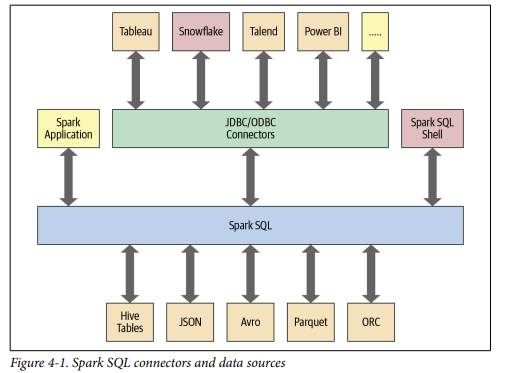
Let’s begin with how you can use Spark SQL in a Spark application.

## Using Spark SQL in Spark Applications
The SparkSession, introduced in Spark 2.0, provides a unified entry point for programming Spark with the Structured APIs. You can use a SparkSession to access
Spark functionality: just import the class and create an instance in your code.

To issue any SQL query, use the sql() method on the SparkSession instance, spark,
such as spark.sql("SELECT * FROM myTableName"). All spark.sql queries executed
in this manner return a DataFrame on which you may perform further Spark operations if you desire—the kind we explored in Chapter 3 and the ones you will learn
about in this chapter and the next.

#### Basic Query Examples
In this section we’ll walk through a few examples of queries on the Airline On-Time
Performance and Causes of Flight Delays data set, which contains data on US flights
including date, delay, distance, origin, and destination. It’s available as a CSV file with
over a million records. Using a schema, we’ll read the data into a DataFrame and reg‐
ister the DataFrame as a temporary view (more on temporary views shortly) so we
can query it with SQL.

Query examples are provided in code snippets, and Python and Scala notebooks
containing all of the code presented here are available in the book’s GitHub repo.
These examples will offer you a taste of how to use SQL in your Spark applications via
the spark.sql programmatic interface. Similar to the DataFrame API in its declarative flavor, this interface allows you to query structured data in your Spark
applications.

Normally, in a standalone Spark application, you will create a SparkSession instance
manually, as shown in the following example. However, in a Spark shell (or Databricks notebook), the SparkSession is created for you and accessible via the appropriately named variable spark.

Let’s get started by reading the data set into a temporary view:
~~~
// In Scala
import org.apache.spark.sql.SparkSession
val spark = SparkSession
 .builder
 .appName("SparkSQLExampleApp")
 .getOrCreate()
// Path to data set
val csvFile="/databricks-datasets/learning-spark-v2/flights/departuredelays.csv"
// Read and create a temporary view
// Infer schema (note that for larger files you may want to specify the schema)
val df = spark.read.format("csv")
 .option("inferSchema", "true")
 .option("header", "true")
 .load(csvFile)
// Create a temporary view
df.createOrReplaceTempView("us_delay_flights_tbl")
# In Python
from pyspark.sql import SparkSession
# Create a SparkSession
spark = (SparkSession
 .builder
 .appName("SparkSQLExampleApp")
 .getOrCreate())
 # Path to data set
csv_file = "/databricks-datasets/learning-spark-v2/flights/departuredelays.csv"
# Read and create a temporary view
# Infer schema (note that for larger files you
# may want to specify the schema)
df = (spark.read.format("csv")
 .option("inferSchema", "true")
 .option("header", "true")
 .load(csv_file))
df.createOrReplaceTempView("us_delay_flights_tbl")
~~~
If you want to specify a schema, you can use a DDL-formatted
string. For example:
~~~
// In Scala
val schema = "date STRING, delay INT, distance INT,
 origin STRING, destination STRING"
# In Python
schema = "`date` STRING, `delay` INT, `distance` INT,
`origin` STRING, `destination` STRING"
~~~
Now that we have a temporary view, we can issue SQL queries using Spark SQL.
These queries are no different from those you might issue against a SQL table in, say,
a MySQL or PostgreSQL database. The point here is to show that Spark SQL offers an
ANSI:2003–compliant SQL interface, and to demonstrate the interoperability
between SQL and DataFrames.

The US flight delays data set has five columns:
* The date column contains a string like 02190925. When converted, this maps to
02-19 09:25 am.
* The delay column gives the delay in minutes between the scheduled and actual
departure times. Early departures show negative numbers.
* The distance column gives the distance in miles from the origin airport to the
destination airport.
* The origin column contains the origin IATA airport code.
* The destination column contains the destination IATA airport code.

With that in mind, let’s try some example queries against this data set.
First, we’ll find all flights whose distance is greater than 1,000 miles:
~~~
spark.sql("""SELECT distance, origin, destination
FROM us_delay_flights_tbl WHERE distance > 1000
ORDER BY distance DESC""").show(10)
+--------+------+-----------+
|distance|origin|destination|
+--------+------+-----------+
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
+--------+------+-----------+
only showing top 10 rows
~~~
As the results show, all of the longest flights were between Honolulu (HNL) and New
York (JFK). Next, we’ll find all flights between San Francisco (SFO) and Chicago
(ORD) with at least a two-hour delay:
~~~
spark.sql("""SELECT date, delay, origin, destination
FROM us_delay_flights_tbl
WHERE delay > 120 AND ORIGIN = 'SFO' AND DESTINATION = 'ORD'
ORDER by delay DESC""").show(10)
+--------+-----+------+-----------+
|date |delay|origin|destination|
+--------+-----+------+-----------+
|02190925|1638 |SFO |ORD |
|01031755|396 |SFO |ORD |
|01022330|326 |SFO |ORD |
|01051205|320 |SFO |ORD |
|01190925|297 |SFO |ORD |
|02171115|296 |SFO |ORD |
|01071040|279 |SFO |ORD |
|01051550|274 |SFO |ORD |
|03120730|266 |SFO |ORD |
|01261104|258 |SFO |ORD |
+--------+-----+------+-----------+
only showing top 10 rows
~~~
It seems there were many significantly delayed flights between these two cities, on different dates. (As an exercise, convert the date column into a readable format and find
the days or months when these delays were most common. Were the delays related to
winter months or holidays?)

Let’s try a more complicated query where we use the CASE clause in SQL. In the following example, we want to label all US flights, regardless of origin and destination,
with an indication of the delays they experienced: Very Long Delays (> 6 hours),
Long Delays (2–6 hours), etc. We’ll add these human-readable labels in a new column
called Flight_Delays:
~~~
spark.sql("""SELECT delay, origin, destination,
 CASE
 WHEN delay > 360 THEN 'Very Long Delays'
 WHEN delay > 120 AND delay < 360 THEN 'Long Delays'
 WHEN delay > 60 AND delay < 120 THEN 'Short Delays'
 WHEN delay > 0 and delay < 60 THEN 'Tolerable Delays'
 WHEN delay = 0 THEN 'No Delays'
 ELSE 'Early'
 END AS Flight_Delays
 FROM us_delay_flights_tbl
 ORDER BY origin, delay DESC""").show(10)
+-----+------+-----------+-------------+
|delay|origin|destination|Flight_Delays|
+-----+------+-----------+-------------+
|333 |ABE |ATL |Long Delays |
|305 |ABE |ATL |Long Delays |
|275 |ABE |ATL |Long Delays |
|257 |ABE |ATL |Long Delays |
|247 |ABE |DTW |Long Delays |
|247 |ABE |ATL |Long Delays |
|219 |ABE |ORD |Long Delays |
|211 |ABE |ATL |Long Delays |
|197 |ABE |DTW |Long Delays |
|192 |ABE |ORD |Long Delays |
+-----+------+-----------+-------------+
only showing top 10 rows
~~~
As with the DataFrame and Dataset APIs, with the spark.sql interface you can conduct common data analysis operations like those we explored in the previous chapter.
The computations undergo an identical journey in the Spark SQL engine (see “The
Catalyst Optimizer” on page 77 in Chapter 3 for details), giving you the same results.

All three of the preceding SQL queries can be expressed with an equivalent DataFrame API query. For example, the first query can be expressed in the Python DataFrame API as:
~~~
# In Python
from pyspark.sql.functions import col, desc
(df.select("distance", "origin", "destination")
 .where(col("distance") > 1000)
 .orderBy(desc("distance"))).show(10)
# Or
(df.select("distance", "origin", "destination")
 .where("distance > 1000")
 .orderBy("distance", ascending=False).show(10))
~~~
This produces the same results as the SQL query:
~~~
+--------+------+-----------+
|distance|origin|destination|
+--------+------+-----------+
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
|4330 |HNL |JFK |
+--------+------+-----------+
only showing top 10 rows
~~~
As an exercise, try converting the other two SQL queries to use the DataFrame API.

As these examples show, using the Spark SQL interface to query data is similar to
writing a regular SQL query to a relational database table. Although the queries are in
SQL, you can feel the similarity in readability and semantics to DataFrame API operations, which you encountered in Chapter 3 and will explore further in the next
chapter.

To enable you to query structured data as shown in the preceding examples, Spark
manages all the complexities of creating and managing views and tables, both in
memory and on disk. That leads us to our next topic: how tables and views are created and managed.

## SQL Tables and Views
Tables hold data. Associated with each table in Spark is its relevant metadata, which is
information about the table and its data: the schema, description, table name, database name, column names, partitions, physical location where the actual data resides,
etc. All of this is stored in a central metastore.

Instead of having a separate metastore for Spark tables, Spark by default uses the
Apache Hive metastore, located at /user/hive/warehouse, to persist all the metadata
about your tables. However, you may change the default location by setting the Spark
config variable spark.sql.warehouse.dir to another location, which can be set to a
local or external distributed storage.

#### Managed Versus UnmanagedTables
Spark allows you to create two types of tables: managed and unmanaged. For a managed table, Spark manages both the metadata and the data in the file store. This could
be a local filesystem, HDFS, or an object store such as Amazon S3 or Azure Blob. For an unmanaged table, Spark only manages the metadata, while you manage the data
yourself in an external data source such as Cassandra.

With a managed table, because Spark manages everything, a SQL command such as
DROP TABLE table_name deletes both the metadata and the data. With an unmanaged
table, the same command will delete only the metadata, not the actual data. We will
look at some examples of how to create managed and unmanaged tables in the next
section.
#### Creating SQL Databases and Tables
Tables reside within a database. By default, Spark creates tables under the default
database. To create your own database name, you can issue a SQL command from
your Spark application or notebook. Using the US flight delays data set, let’s create
both a managed and an unmanaged table. To begin, we’ll create a database called
learn_spark_db and tell Spark we want to use that database:
~~~
// In Scala/Python
spark.sql("CREATE DATABASE learn_spark_db")
spark.sql("USE learn_spark_db")
~~~
From this point, any commands we issue in our application to create tables will result
in the tables being created in this database and residing under the database name
learn_spark_db.

___Creating a managed table___

To create a managed table within the database learn_spark_db, you can issue a SQL
query like the following:
~~~
// In Scala/Python
spark.sql("CREATE TABLE managed_us_delay_flights_tbl (date STRING, delay INT,
 distance INT, origin STRING, destination STRING)")
You can do the same thing using the DataFrame API like this:
# In Python
# Path to our US flight delays CSV file
csv_file = "/databricks-datasets/learning-spark-v2/flights/departuredelays.csv"
# Schema as defined in the preceding example
schema="date STRING, delay INT, distance INT, origin STRING, destination STRING"
flights_df = spark.read.csv(csv_file, schema=schema)
flights_df.write.saveAsTable("managed_us_delay_flights_tbl")
~~~
Both of these statements will create the managed table us_delay_flights_tbl in the
learn_spark_db database.

___Creating an unmanaged table___

By contrast, you can create unmanaged tables from your own data sources—say, Par‐
quet, CSV, or JSON files stored in a file store accessible to your Spark application.

To create an unmanaged table from a data source such as a CSV file, in SQL use:
~~~
spark.sql("""CREATE TABLE us_delay_flights_tbl(date STRING, delay INT,
 distance INT, origin STRING, destination STRING)
 USING csv OPTIONS (PATH
 '/databricks-datasets/learning-spark-v2/flights/departuredelays.csv')""")
~~~
And within the DataFrame API use:
~~~
(flights_df
 .write
 .option("path", "/tmp/data/us_flights_delay")
 .saveAsTable("us_delay_flights_tbl"))
~~~
To enable you to explore these examples, we have created Python
and Scala example notebooks that you can find in the book’s Git‐
Hub repo
#### Creating Views
In addition to creating tables, Spark can create views on top of existing tables. Views
can be global (visible across all SparkSessions on a given cluster) or session-scoped
(visible only to a single SparkSession), and they are temporary: they disappear after
your Spark application terminates.

Creating views has a similar syntax to creating tables within a database. Once you create a view, you can query it as you would a table. The difference between a view and a
table is that views don’t actually hold the data; tables persist after your Spark application terminates, but views disappear.

You can create a view from an existing table using SQL. For example, if you wish to
work on only the subset of the US flight delays data set with origin airports of New
York (JFK) and San Francisco (SFO), the following queries will create global temporary and temporary views consisting of just that slice of the table:
~~~
-- In SQL
CREATE OR REPLACE GLOBAL TEMP VIEW us_origin_airport_SFO_global_tmp_view AS
 SELECT date, delay, origin, destination from us_delay_flights_tbl WHERE
 origin = 'SFO';
CREATE OR REPLACE TEMP VIEW us_origin_airport_JFK_tmp_view AS
 SELECT date, delay, origin, destination from us_delay_flights_tbl WHERE
 origin = 'JFK'
 ~~~
You can accomplish the same thing with the DataFrame API as follows:
~~~
# In Python
df_sfo = spark.sql("SELECT date, delay, origin, destination FROM
 us_delay_flights_tbl WHERE origin = 'SFO'")
df_jfk = spark.sql("SELECT date, delay, origin, destination FROM
 us_delay_flights_tbl WHERE origin = 'JFK'")
# Create a temporary and global temporary view
df_sfo.createOrReplaceGlobalTempView("us_origin_airport_SFO_global_tmp_view")
df_jfk.createOrReplaceTempView("us_origin_airport_JFK_tmp_view")
~~~
Once you’ve created these views, you can issue queries against them just as you would
against a table. Keep in mind that when accessing a global temporary view you must
use the prefix global_temp.<view_name>, because Spark creates global temporary
views in a global temporary database called global_temp. For example:
~~~
-- In SQL
SELECT * FROM global_temp.us_origin_airport_SFO_global_tmp_view
~~~
By contrast, you can access the normal temporary view without the global_temp
prefix:
~~~
-- In SQL
SELECT * FROM us_origin_airport_JFK_tmp_view
// In Scala/Python
spark.read.table("us_origin_airport_JFK_tmp_view")
// Or
spark.sql("SELECT * FROM us_origin_airport_JFK_tmp_view")
~~~
You can also drop a view just like you would a table:
~~~
-- In SQL
DROP VIEW IF EXISTS us_origin_airport_SFO_global_tmp_view;
DROP VIEW IF EXISTS us_origin_airport_JFK_tmp_view
// In Scala/Python
spark.catalog.dropGlobalTempView("us_origin_airport_SFO_global_tmp_view")
spark.catalog.dropTempView("us_origin_airport_JFK_tmp_view")
~~~

___Temporary views versus global temporary views___

The difference between temporary and global temporary views being subtle, it can be a
source of mild confusion among developers new to Spark. A temporary view is tied
to a single SparkSession within a Spark application. In contrast, a global temporary
view is visible across multiple SparkSessions within a Spark application. Yes, you can
create multiple SparkSessions within a single Spark application—this can be handy,
for example, in cases where you want to access (and combine) data from two different
SparkSessions that don’t share the same Hive metastore configurations. 

#### Viewing the Metadata
As mentioned previously, Spark manages the metadata associated with each managed
or unmanaged table. This is captured in the Catalog, a high-level abstraction in
Spark SQL for storing metadata. The Catalog’s functionality was expanded in Spark
2.x with new public methods enabling you to examine the metadata associated with
your databases, tables, and views. Spark 3.0 extends it to use external catalog (which
we briefly discuss in Chapter 12).

For example, within a Spark application, after creating the SparkSession variable
spark, you can access all the stored metadata through methods like these:
~~~
// In Scala/Python
spark.catalog.listDatabases()
spark.catalog.listTables()
spark.catalog.listColumns("us_delay_flights_tbl")
~~~
Import the notebook from the book’s GitHub repo and give it a try.
#### Caching SQL Tables
Although we will discuss table caching strategies in the next chapter, it’s worth mentioning here that, like DataFrames, you can cache and uncache SQL tables and views.
In Spark 3.0, in addition to other options, you can specify a table as LAZY, meaning
that it should only be cached when it is first used instead of immediately:
~~~
-- In SQL
CACHE [LAZY] TABLE <table-name>
UNCACHE TABLE <table-name>
~~~
#### Reading Tables into DataFrames
Often, data engineers build data pipelines as part of their regular data ingestion and
ETL processes. They populate Spark SQL databases and tables with cleansed data for
consumption by applications downstream.

Let’s assume you have an existing database, learn_spark_db, and table,
us_delay_flights_tbl, ready for use. Instead of reading from an external JSON file,
you can simply use SQL to query the table and assign the returned result to a
DataFrame:
~~~
// In Scala
val usFlightsDF = spark.sql("SELECT * FROM us_delay_flights_tbl")
val usFlightsDF2 = spark.table("us_delay_flights_tbl")
# In Python
us_flights_df = spark.sql("SELECT * FROM us_delay_flights_tbl")
us_flights_df2 = spark.table("us_delay_flights_tbl")
~~~
Now you have a cleansed DataFrame read from an existing Spark SQL table. You can
also read data in other formats using Spark’s built-in data sources, giving you the flex‐
ibility to interact with various common file formats.

## Data Sources for DataFrames and SQL Tables
As shown in Figure 4-1, Spark SQL provides an interface to a variety of data sources.
It also provides a set of common methods for reading and writing data to and from
these data sources using the Data Sources API.

In this section we will cover some of the built-in data sources, available file formats,
and ways to load and write data, along with specific options pertaining to these data
sources. But first, let’s take a closer look at two high-level Data Source API constructs
that dictate the manner in which you interact with different data sources: DataFrameR
eader and DataFrameWriter.

#### DataFrameReader
DataFrameReader is the core construct for reading data from a data source into a
DataFrame. It has a defined format and a recommended pattern for usage:
~~~
DataFrameReader.format(args).option("key", "value").schema(args).load()
~~~
This pattern of stringing methods together is common in Spark, and easy to read. We
saw it in Chapter 3 when exploring common data analysis patterns.

Note that you can only access a DataFrameReader through a SparkSession instance.
That is, you cannot create an instance of DataFrameReader. To get an instance handle
to it, use:
~~~
SparkSession.read
// or
SparkSession.readStream
~~~
While read returns a handle to DataFrameReader to read into a DataFrame from a
static data source, readStream returns an instance to read from a streaming source.
(We will cover Structured Streaming later in the book.)

Arguments to each of the public methods to DataFrameReader take different values.
Table 4-1 enumerates these, with a subset of the supported arguments.
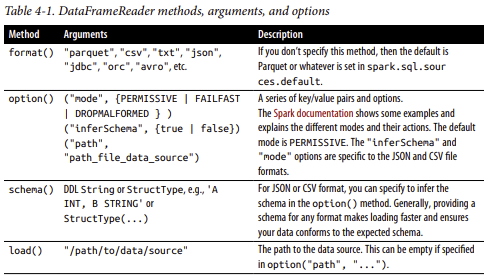
While we won’t comprehensively enumerate all the different combinations of arguments and options, the documentation for Python, Scala, R, and Java offers suggestions and guidance. It’s worthwhile to show a couple of examples, though:
~~~
// In Scala
// Use Parquet
val file = """/databricks-datasets/learning-spark-v2/flights/summary-
 data/parquet/2010-summary.parquet"""
val df = spark.read.format("parquet").load(file)
// Use Parquet; you can omit format("parquet") if you wish as it's the default
val df2 = spark.read.load(file)
// Use CSV
val df3 = spark.read.format("csv")
 .option("inferSchema", "true")
 .option("header", "true")
 .option("mode", "PERMISSIVE")
 .load("/databricks-datasets/learning-spark-v2/flights/summary-data/csv/*")
// Use JSON
val df4 = spark.read.format("json")
 .load("/databricks-datasets/learning-spark-v2/flights/summary-data/json/*")
 ~~~
 In general, no schema is needed when reading from a static Parquet
data source—the Parquet metadata usually contains the schema, so
it’s inferred. However, for streaming data sources you will have to
provide a schema. (We will cover reading from streaming data
sources in Chapter 8.)

Parquet is the default and preferred data source for Spark because
it’s efficient, uses columnar storage, and employs a fast compression algorithm. You will see additional benefits later (such as columnar pushdown), when we cover the Catalyst optimizer in greater depth.
#### DataFrameWriter
DataFrameWriter does the reverse of its counterpart: it saves or writes data to a specified built-in data source. Unlike with DataFrameReader, you access its instance not
from a SparkSession but from the DataFrame you wish to save. It has a few recommended usage patterns:
~~~
DataFrameWriter.format(args)
 .option(args)
 .bucketBy(args)
 .partitionBy(args)
 .save(path)
 
DataFrameWriter.format(args).option(args).sortBy(args).saveAsTable(table)
~~~
To get an instance handle, use:
~~~
DataFrame.write
// or
DataFrame.writeStream
~~~
Arguments to each of the methods to DataFrameWriter also take different values. We
list these in Table 4-2, with a subset of the supported arguments.

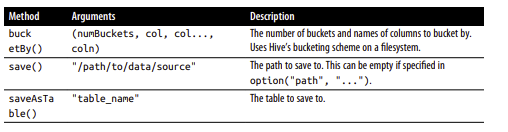
Here’s a short example snippet to illustrate the use of methods and arguments:
~~~
// In Scala
// Use JSON
val location = ...
df.write.format("json").mode("overwrite").save(location)
~~~
#### Parquet
We’ll start our exploration of data sources with Parquet, because it’s the default data
source in Spark. Supported and widely used by many big data processing frameworks
and platforms, Parquet is an open source columnar file format that offers many I/O
optimizations (such as compression, which saves storage space and allows for quick
access to data columns).

Because of its efficiency and these optimizations, we recommend that after you have
transformed and cleansed your data, you save your DataFrames in the Parquet format
for downstream consumption. (Parquet is also the default table open format for Delta
Lake, which we will cover in Chapter 9.)

___Reading Parquet files into a DataFrame___

Parquet files are stored in a directory structure that contains the data files, metadata,
a number of compressed files, and some status files. Metadata in the footer contains
the version of the file format, the schema, and column data such as the path, etc.

For example, a directory in a Parquet file might contain a set of files like this:
~~~
_SUCCESS
_committed_1799640464332036264
_started_1799640464332036264
part-00000-tid-1799640464332036264-91273258-d7ef-4dc7-<...>-c000.snappy.parquet
~~~
There may be a number of part-XXXX compressed files in a directory (the names
shown here have been shortened to fit on the page).

To read Parquet files into a DataFrame, you simply specify the format and path:
~~~
// In Scala
val file = """/databricks-datasets/learning-spark-v2/flights/summary-data/
 parquet/2010-summary.parquet/"""
val df = spark.read.format("parquet").load(file)
# In Python
file = """/databricks-datasets/learning-spark-v2/flights/summary-data/parquet/
 2010-summary.parquet/"""
df = spark.read.format("parquet").load(file)
~~~
Unless you are reading from a streaming data source there’s no need to supply the
schema, because Parquet saves it as part of its metadata.

___Reading Parquet files into a Spark SQL table___

As well as reading Parquet files into a Spark DataFrame, you can also create a Spark
SQL unmanaged table or view directly using SQL:
~~~
-- In SQL
CREATE OR REPLACE TEMPORARY VIEW us_delay_flights_tbl
 USING parquet
 OPTIONS (
 path "/databricks-datasets/learning-spark-v2/flights/summary-data/parquet/
 2010-summary.parquet/" )
 ~~~
Once you’ve created the table or view, you can read data into a DataFrame using SQL,
as we saw in some earlier examples:
~~~
// In Scala
spark.sql("SELECT * FROM us_delay_flights_tbl").show()
# In Python
spark.sql("SELECT * FROM us_delay_flights_tbl").show()
~~~
Both of these operations return the same results:
~~~
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States |Romania |1 |
|United States |Ireland |264 |
|United States |India |69 |
|Egypt |United States |24 |
|Equatorial Guinea|United States |1 |
|United States |Singapore |25 |
|United States |Grenada |54 |
|Costa Rica |United States |477 |
|Senegal |United States |29 |
|United States |Marshall Islands |44 |
+-----------------+-------------------+-----+
only showing top 10 rows
~~~
___Writing DataFrames to Parquet files___

Writing or saving a DataFrame as a table or file is a common operation in Spark. To
write a DataFrame you simply use the methods and arguments to the DataFrame
Writer outlined earlier in this chapter, supplying the location to save the Parquet files
to. For example:
~~~
// In Scala
df.write.format("parquet")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("/tmp/data/parquet/df_parquet")
# In Python
(df.write.format("parquet")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("/tmp/data/parquet/df_parquet"))
 ~~~
Recall that Parquet is the default file format. If you don’t include
the format() method, the DataFrame will still be saved as a Parquet file.

This will create a set of compact and compressed Parquet files at the specified path.
Since we used snappy as our compression choice here, we’ll have snappy compressed
files. For brevity, this example generated only one file; normally, there may be a dozen
or so files created:
~~~
-rw-r--r-- 1 jules wheel 0 May 19 10:58 _SUCCESS
-rw-r--r-- 1 jules wheel 966 May 19 10:58 part-00000-<...>-c000.snappy.parquet
~~~
___Writing DataFrames to Spark SQL tables___

Writing a DataFrame to a SQL table is as easy as writing to a file—just use saveAsTa
ble() instead of save(). This will create a managed table called
us_delay_flights_tbl:
~~~
// In Scala
df.write
 .mode("overwrite")
 .saveAsTable("us_delay_flights_tbl")
# In Python
(df.write
 .mode("overwrite")
 .saveAsTable("us_delay_flights_tbl"))
 ~~~
To sum up, Parquet is the preferred and default built-in data source file format in
Spark, and it has been adopted by many other frameworks. We recommend that you
use this format in your ETL and data ingestion processes.
#### JSON
JavaScript Object Notation (JSON) is also a popular data format. It came to prominence as an easy-to-read and easy-to-parse format compared to XML. It has two representational formats: single-line mode and multiline mode. Both modes are
supported in Spark.

In single-line mode each line denotes a single JSON object, whereas in multiline
mode the entire multiline object constitutes a single JSON object. To read in this
mode, set multiLine to true in the option() method.

___Reading a JSON file into a DataFrame___

You can read a JSON file into a DataFrame the same way you did with Parquet—just
specify "json" in the format() method:
~~~
// In Scala
val file = "/databricks-datasets/learning-spark-v2/flights/summary-data/json/*"
val df = spark.read.format("json").load(file)
# In Python
file = "/databricks-datasets/learning-spark-v2/flights/summary-data/json/*"
df = spark.read.format("json").load(file)
~~~
___Reading a JSON file into a Spark SQL table___

You can also create a SQL table from a JSON file just like you did with Parquet:
~~~
-- In SQL
CREATE OR REPLACE TEMPORARY VIEW us_delay_flights_tbl
 USING json
 OPTIONS (
 path "/databricks-datasets/learning-spark-v2/flights/summary-data/json/*"
 )
 ~~~
Once the table is created, you can read data into a DataFrame using SQL:
~~~
// In Scala/Python
spark.sql("SELECT * FROM us_delay_flights_tbl").show()
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States |Romania |15 |
|United States |Croatia |1 |
|United States |Ireland |344 |
|Egypt |United States |15 |
|United States |India |62 |
|United States |Singapore |1 |
|United States |Grenada |62 |
|Costa Rica |United States |588 |
|Senegal |United States |40 |
|Moldova |United States |1 |
+-----------------+-------------------+-----+
only showing top 10 rows
~~~
___Writing DataFrames to JSON files___

Saving a DataFrame as a JSON file is simple. Specify the appropriate
DataFrameWriter methods and arguments, and supply the location to save the JSON
files to:
~~~
// In Scala
df.write.format("json")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("/tmp/data/json/df_json")
# In Python
(df.write.format("json")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("/tmp/data/json/df_json"))
 ~~~
This creates a directory at the specified path populated with a set of compact JSON
files:
~~~
-rw-r--r-- 1 jules wheel 0 May 16 14:44 _SUCCESS
-rw-r--r-- 1 jules wheel 71 May 16 14:44 part-00000-<...>-c000.json
~~~
___JSON data source options___

Table 4-3 describes common JSON options for DataFrameReader and DataFrame
Writer. For a comprehensive list, we refer you to the documentation.


#### CSV
As widely used as plain text files, this common text file format captures each datum
or field delimited by a comma; each line with comma-separated fields represents a
record. Even though a comma is the default separator, you may use other delimiters
to separate fields in cases where commas are part of your data. Popular spreadsheets
can generate CSV files, so it’s a popular format among data and business analysts.

___Reading a CSV file into a DataFrame___

As with the other built-in data sources, you can use the DataFrameReader methods
and arguments to read a CSV file into a DataFrame:
~~~
// In Scala
val file = "/databricks-datasets/learning-spark-v2/flights/summary-data/csv/*"
val schema = "DEST_COUNTRY_NAME STRING, ORIGIN_COUNTRY_NAME STRING, count INT"
val df = spark.read.format("csv")
 .schema(schema)
 .option("header", "true")
 .option("mode", "FAILFAST") // Exit if any errors
 .option("nullValue", "") // Replace any null data with quotes
 .load(file)
# In Python
file = "/databricks-datasets/learning-spark-v2/flights/summary-data/csv/*"
schema = "DEST_COUNTRY_NAME STRING, ORIGIN_COUNTRY_NAME STRING, count INT"
df = (spark.read.format("csv")
 .option("header", "true")
 .schema(schema)
 .option("mode", "FAILFAST") # Exit if any errors
 .option("nullValue", "") # Replace any null data field with quotes
 .load(file))
 ~~~
___Reading a CSV file into a Spark SQL table___

Creating a SQL table from a CSV data source is no different from using Parquet or
JSON:
~~~
-- In SQL
CREATE OR REPLACE TEMPORARY VIEW us_delay_flights_tbl
 USING csv
 OPTIONS (
 path "/databricks-datasets/learning-spark-v2/flights/summary-data/csv/*",
 header "true",
 inferSchema "true",
 mode "FAILFAST"
 )
 ~~~
Once you’ve created the table, you can read data into a DataFrame using SQL as
before:
~~~
// In Scala/Python
spark.sql("SELECT * FROM us_delay_flights_tbl").show(10)
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States |Romania |1 |
|United States |Ireland |264 |
|United States |India |69 |
|Egypt |United States |24 |
|Equatorial Guinea|United States |1 |
|United States |Singapore |25 |
|United States |Grenada |54 |
|Costa Rica |United States |477 |
|Senegal |United States |29 |
|United States |Marshall Islands |44 |
+-----------------+-------------------+-----+
only showing top 10 rows
~~~
___Writing DataFrames to CSV files___

Saving a DataFrame as a CSV file is simple. Specify the appropriate DataFrameWriter
methods and arguments, and supply the location to save the CSV files to:
~~~
// In Scala
df.write.format("csv").mode("overwrite").save("/tmp/data/csv/df_csv")
# In Python
df.write.format("csv").mode("overwrite").save("/tmp/data/csv/df_csv")
~~~
This generates a folder at the specified location, populated with a bunch of compressed and compact files:
~~~
-rw-r--r-- 1 jules wheel 0 May 16 12:17 _SUCCESS
-rw-r--r-- 1 jules wheel 36 May 16 12:17 part-00000-251690eb-<...>-c000.csv
~~~
___CSV data source options___

Table 4-4 describes some of the common CSV options for DataFrameReader and Data
FrameWriter. Because CSV files can be complex, many options are available; for a
comprehensive list we refer you to the documentation.
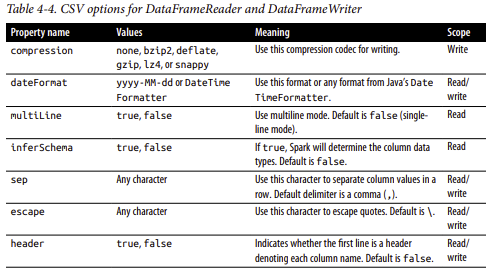

#### Avro
Introduced in Spark 2.4 as a built-in data source, the Avro format is used, for example, by Apache Kafka for message serializing and deserializing. It offers many benefits, including direct mapping to JSON, speed and efficiency, and bindings available
for many programming languages.

___Reading an Avro file into a DataFrame___

Reading an Avro file into a DataFrame using DataFrameReader is consistent in usage
with the other data sources we have discussed in this section:
~~~
// In Scala
val df = spark.read.format("avro")
.load("/databricks-datasets/learning-spark-v2/flights/summary-data/avro/*")
df.show(false)
# In Python
df = (spark.read.format("avro")
 .load("/databricks-datasets/learning-spark-v2/flights/summary-data/avro/*"))
df.show(truncate=False)
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States |Romania |1 |
|United States |Ireland |264 |
|United States |India |69 |
|Egypt |United States |24 |
|Equatorial Guinea|United States |1 |
|United States |Singapore |25 |
|United States |Grenada |54 |
|Costa Rica |United States |477 |
|Senegal |United States |29 |
|United States |Marshall Islands |44 |
+-----------------+-------------------+-----+
only showing top 10 rows
~~~

___Reading an Avro file into a Spark SQL table___

Again, creating SQL tables using an Avro data source is no different from using Par‐
quet, JSON, or CSV:
~~~
-- In SQL
CREATE OR REPLACE TEMPORARY VIEW episode_tbl
 USING avro
 OPTIONS (
 path "/databricks-datasets/learning-spark-v2/flights/summary-data/avro/*"
 )
~~~
Once you’ve created a table, you can read data into a DataFrame using SQL:
~~~
// In Scala
spark.sql("SELECT * FROM episode_tbl").show(false)
# In Python
spark.sql("SELECT * FROM episode_tbl").show(truncate=False)
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States |Romania |1 |
|United States |Ireland |264 |
|United States |India |69 |
|Egypt |United States |24 |
|Equatorial Guinea|United States |1 |
|United States |Singapore |25 |
|United States |Grenada |54 |
|Costa Rica |United States |477 |
|Senegal |United States |29 |
|United States |Marshall Islands |44 |
+-----------------+-------------------+-----+
only showing top 10 rows
~~~

___Writing DataFrames to Avro files___

Writing a DataFrame as an Avro file is simple. As usual, specify the appropriate Data
FrameWriter methods and arguments, and supply the location to save the Avro files
to:
~~~
// In Scala
df.write
 .format("avro")
 .mode("overwrite")
 .save("/tmp/data/avro/df_avro")
# In Python
(df.write
 .format("avro")
 .mode("overwrite")
 .save("/tmp/data/avro/df_avro"))
 ~~~
This generates a folder at the specified location, populated with a bunch of com‐
pressed and compact files:
~~~
-rw-r--r-- 1 jules wheel 0 May 17 11:54 _SUCCESS
-rw-r--r-- 1 jules wheel 526 May 17 11:54 part-00000-ffdf70f4-<...>-c000.avro
~~~

___Avro data source options___

Table 4-5 describes common options for DataFrameReader and DataFrameWriter. A
comprehensive list of options is in the documentation.


#### ORC
As an additional optimized columnar file format, Spark 2.x supports a vectorized
ORC reader. Two Spark configurations dictate which ORC implementation to use.
When spark.sql.orc.impl is set to native and spark.sql.orc.enableVectorize
dReader is set to true, Spark uses the vectorized ORC reader. A vectorized reader reads blocks of rows (often 1,024 per block) instead of one row at a time, streamlining
operations and reducing CPU usage for intensive operations like scans, filters, aggre‐
gations, and joins.

For Hive ORC SerDe (serialization and deserialization) tables created with the SQL
command USING HIVE OPTIONS (fileFormat 'ORC'), the vectorized reader is used
when the Spark configuration parameter spark.sql.hive.convertMetastoreOrc is
set to true.

___Reading an ORC file into a DataFrame___

To read in a DataFrame using the ORC vectorized reader, you can just use the normal
DataFrameReader methods and options:
~~~
// In Scala
val file = "/databricks-datasets/learning-spark-v2/flights/summary-data/orc/*"
val df = spark.read.format("orc").load(file)
df.show(10, false)
# In Python
file = "/databricks-datasets/learning-spark-v2/flights/summary-data/orc/*"
df = spark.read.format("orc").option("path", file).load()
df.show(10, False)
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States |Romania |1 |
|United States |Ireland |264 |
|United States |India |69 |
|Egypt |United States |24 |
|Equatorial Guinea|United States |1 |
|United States |Singapore |25 |
|United States |Grenada |54 |
|Costa Rica |United States |477 |
|Senegal |United States |29 |
|United States |Marshall Islands |44 |
+-----------------+-------------------+-----+
only showing top 10 rows
~~~

___Reading an ORC file into a Spark SQL table___

There is no difference from Parquet, JSON, CSV, or Avro when creating a SQL view
using an ORC data source:
~~~
-- In SQL
CREATE OR REPLACE TEMPORARY VIEW us_delay_flights_tbl
 USING orc
 OPTIONS (
 path "/databricks-datasets/learning-spark-v2/flights/summary-data/orc/*"
 )
~~~
Once a table is created, you can read data into a DataFrame using SQL as usual:
~~~
// In Scala/Python
spark.sql("SELECT * FROM us_delay_flights_tbl").show()
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|United States |Romania |1 |
|United States |Ireland |264 |
|United States |India |69 |
|Egypt |United States |24 |
|Equatorial Guinea|United States |1 |
|United States |Singapore |25 |
|United States |Grenada |54 |
|Costa Rica |United States |477 |
|Senegal |United States |29 |
|United States |Marshall Islands |44 |
+-----------------+-------------------+-----+
only showing top 10 rows
~~~

___Writing DataFrames to ORC files___

Writing back a transformed DataFrame after reading is equally simple using the
DataFrameWriter methods:
~~~
// In Scala
df.write.format("orc")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("/tmp/data/orc/df_orc")
# In Python
(df.write.format("orc")
 .mode("overwrite")
 .option("compression", "snappy")
 .save("/tmp/data/orc/flights_orc"))
 ~~~
The result will be a folder at the specified location containing some compressed ORC
files:
~~~
-rw-r--r-- 1 jules wheel 0 May 16 17:23 _SUCCESS
-rw-r--r-- 1 jules wheel 547 May 16 17:23 part-00000-<...>-c000.snappy.orc
~~~

#### Images
In Spark 2.4 the community introduced a new data source, image files, to support
deep learning and machine learning frameworks such as TensorFlow and PyTorch.
For computer vision–based machine learning applications, loading and processing
image data sets is important.

___Reading an image file into a DataFrame___

As with all of the previous file formats, you can use the DataFrameReader methods
and options to read in an image file as shown here:
~~~
// In Scala
import org.apache.spark.ml.source.image
val imageDir = "/databricks-datasets/learning-spark-v2/cctvVideos/train_images/"
val imagesDF = spark.read.format("image").load(imageDir)
imagesDF.printSchema
imagesDF.select("image.height", "image.width", "image.nChannels", "image.mode",
 "label").show(5, false)
# In Python
from pyspark.ml import image
image_dir = "/databricks-datasets/learning-spark-v2/cctvVideos/train_images/"
images_df = spark.read.format("image").load(image_dir)
images_df.printSchema()
root
|-- image: struct (nullable = true)
| |-- origin: string (nullable = true)
| |-- height: integer (nullable = true)
| |-- width: integer (nullable = true)
| |-- nChannels: integer (nullable = true)
| |-- mode: integer (nullable = true)
| |-- data: binary (nullable = true)
|-- label: integer (nullable = true)
images_df.select("image.height", "image.width", "image.nChannels", "image.mode",
 "label").show(5, truncate=False)
+------+-----+---------+----+-----+
|height|width|nChannels|mode|label|
+------+-----+---------+----+-----+
|288 |384 |3 |16 |0 |
|288 |384 |3 |16 |1 |•
|288 |384 |3 |16 |0 |
|288 |384 |3 |16 |0 |
|288 |384 |3 |16 |0 |
+------+-----+---------+----+-----+
only showing top 5 rows
~~~

#### Binary Files
Spark 3.0 adds support for binary files as a data source. The DataFrameReader converts each binary file into a single DataFrame row (record) that contains the raw content and metadata of the file. The binary file data source produces a DataFrame with
the following columns:
* path: StringType
* modificationTime: TimestampType
* length: LongType
* content: BinaryType

___Reading a binary file into a DataFrame___

To read binary files, specify the data source format as a binaryFile. You can load files
with paths matching a given global pattern while preserving the behavior of partition
discovery with the data source option pathGlobFilter. For example, the following
code reads all JPG files from the input directory with any partitioned directories:
~~~
// In Scala
val path = "/databricks-datasets/learning-spark-v2/cctvVideos/train_images/"
val binaryFilesDF = spark.read.format("binaryFile")
 .option("pathGlobFilter", "*.jpg")
 .load(path)
binaryFilesDF.show(5)
# In Python
path = "/databricks-datasets/learning-spark-v2/cctvVideos/train_images/"
binary_files_df = (spark.read.format("binaryFile")
 .option("pathGlobFilter", "*.jpg")
 .load(path))
binary_files_df.show(5)
+--------------------+-------------------+------+--------------------+-----+
| path| modificationTime|length| content|label|
+--------------------+-------------------+------+--------------------+-----+
|file:/Users/jules...|2020-02-12 12:04:24| 55037|[FF D8 FF E0 00 1...| 0|
|file:/Users/jules...|2020-02-12 12:04:24| 54634|[FF D8 FF E0 00 1...| 1|
|file:/Users/jules...|2020-02-12 12:04:24| 54624|[FF D8 FF E0 00 1...| 0|
|file:/Users/jules...|2020-02-12 12:04:24| 54505|[FF D8 FF E0 00 1...| 0|
|file:/Users/jules...|2020-02-12 12:04:24| 54475|[FF D8 FF E0 00 1...| 0|
+--------------------+-------------------+------+--------------------+-----+
only showing top 5 rows
~~~
To ignore partitioning data discovery in a directory, you can set recursiveFile
Lookup to "true":
~~~
// In Scala
val binaryFilesDF = spark.read.format("binaryFile")
 .option("pathGlobFilter", "*.jpg")
 .option("recursiveFileLookup", "true")
 .load(path)
binaryFilesDF.show(5)
# In Python
binary_files_df = (spark.read.format("binaryFile")
 .option("pathGlobFilter", "*.jpg")
 .option("recursiveFileLookup", "true")
 .load(path))
binary_files_df.show(5)
+--------------------+-------------------+------+--------------------+
| path| modificationTime|length| content|
+--------------------+-------------------+------+--------------------+
|file:/Users/jules...|2020-02-12 12:04:24| 55037|[FF D8 FF E0 00 1...|
|file:/Users/jules...|2020-02-12 12:04:24| 54634|[FF D8 FF E0 00 1...|
|file:/Users/jules...|2020-02-12 12:04:24| 54624|[FF D8 FF E0 00 1...|
|file:/Users/jules...|2020-02-12 12:04:24| 54505|[FF D8 FF E0 00 1...|
|file:/Users/jules...|2020-02-12 12:04:24| 54475|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows
~~~
Note that the label column is absent when the recursiveFileLookup option is set to
"true".

Currently, the binary file data source does not support writing a DataFrame back to
the original file format.

In this section, you got a tour of how to read data into a DataFrame from a range of
supported file formats. We also showed you how to create temporary views and tables
from the existing built-in data sources. Whether you’re using the DataFrame API or
SQL, the queries produce identical outcomes. You can examine some of these queries
in the notebook available in the GitHub repo for this book.

## Summary
To recap, this chapter explored the interoperability between the DataFrame API and
Spark SQL. In particular, you got a flavor of how to use Spark SQL to:
* Create managed and unmanaged tables using Spark SQL and the DataFrame
API.
* Read from and write to various built-in data sources and file formats.
* Employ the spark.sql programmatic interface to issue SQL queries on struc‐
tured data stored as Spark SQL tables or views.
* Peruse the Spark Catalog to inspect metadata associated with tables and views.
* Use the DataFrameWriter and DataFrameReader APIs.

Through the code snippets in the chapter and the notebooks available in the book’s
GitHub repo, you got a feel for how to use DataFrames and Spark SQL. Continuing in
this vein, the next chapter further explores how Spark interacts with the external data
sources shown in Figure 4-1. You’ll see some more in-depth examples of transformations and the interoperability between the DataFrame API and Spark SQL.